# Ejemplo CNN para detección de objetos

El código a continuación presenta un ejemplo de implementación de una CNN para la detección de objetos, en este caso se utilizará el [conjunto de datos CelebA](https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8?resourcekey=0-5BR16BdXnb8hVj6CNHKzLg) que contiene 202599 imágenes de celebridades. Para cada imágen se cuenta con 40 atributos binarios para el rostro que incluyen cuándo una celebridad está sonriendo (o no) y su edad (joven o viejo).

Para este ejemplo se utiliza una muestra de 16000 imágenes como entrenamiento y un aumento en los datos para evitar el sobre ajuste.

Se recomienda el siguiente [enlace](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html) como explicación del proceso de entrenamiento en pytorch así como la [documentación de la librería](https://pytorch.org/docs/stable/index.html).

In [48]:
import torchvision
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torchvision import datasets
import torch

import matplotlib.pyplot as plt
import numpy as np

## Cargando el conjunto de datos CelebA

Para descargar el conjunto de datos directamente de la librería utilizamos el siguiente código



``` python
image_path = './'
celeba_train_dataset = torchvision.datasets.CelebA(
    image_path, split='train',
    target_type= 'attr', download=True
)

celeba_valid_dataset = torchvision.datasets.CelebA(
    image_path, split='valid',
    target_type='attr', download=True
)

celeba_test_dataset = torchvision.datasets.CelebA(
    image_path, split='test',
    target_type='attr', download=True
)

```

lastimosamente el conjunto de datos CelebA es relativamente largo (aproximadamente 1.5 Gb) y el enlace de descarga en la librería es inestable por lo que es común [descargarlo manualmente](https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8?resourcekey=0-5BR16BdXnb8hVj6CNHKzLg) y descomprimirlo en el entorno para poder utilizarlo. Cabe resaltar que el conjunto de datos aún comprimido puede tardar unos minutos en cargar en el entorno de Google Colab por lo que ejecutar el siguiente código puede tomar algunos minutos.

De drive necesitaremos los archivos:

```img_align_celeba.zip```

```identity_CelebA.txt```

```list_attr_celeba.txt```

```list_bbox_celeba.txt```

```list_eval_partition.txt```

```list_landmarks_align_celeba.txt```





In [28]:
import zipfile

In [29]:
#### Extracción del archivo

path_to_zip_file = '/content/img_align_celeba.zip'
directory_to_extract_to = "/content/"

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)



Una vez extraído el archivo .zip incluiremos esta carpeta junto con los archivos .txt en una nueva carpeta llamada ```celeba```.

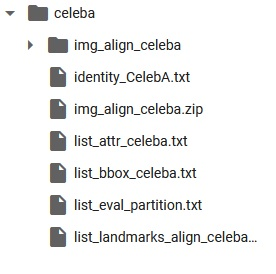

In [30]:
#### Carga de los conjuntos de datos
image_path = '/content'

celeba_train_dataset = torchvision.datasets.CelebA(
    image_path, split='train',
    target_type= 'attr', download=False
)

celeba_valid_dataset = torchvision.datasets.CelebA(
    image_path, split='valid',
    target_type='attr', download=False
)

celeba_test_dataset = torchvision.datasets.CelebA(
    image_path, split='test',
    target_type='attr', download=False
)

print('Conjunto de entrenamiento:', len(celeba_train_dataset))
print('Conjunto de validación', len(celeba_valid_dataset))
print('Conjunto de prueba', len(celeba_test_dataset))

Conjunto de entrenamiento: 162770
Conjunto de validación 19867
Conjunto de prueba 19962


## Transformación de imágenes y aumento de datos

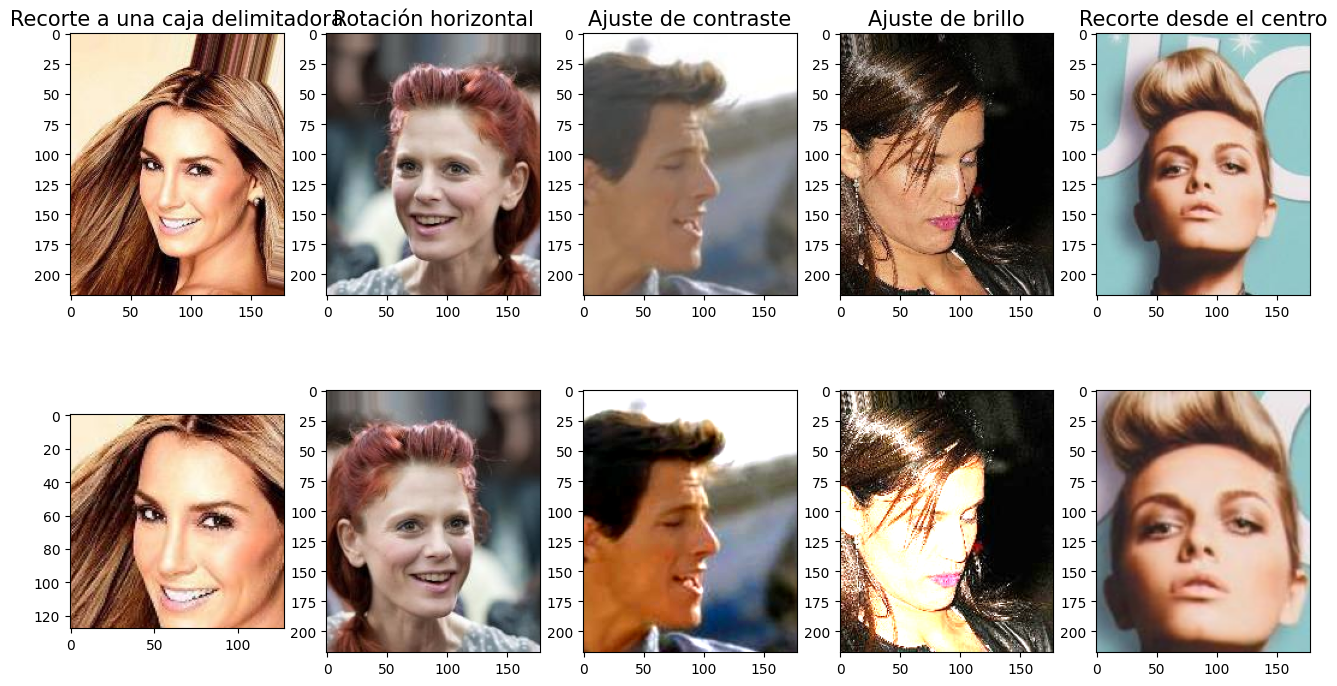

In [31]:
fig = plt.figure(figsize=(16, 8.5))

## Columna 1: recortando con la forma de una caja delimitadora

ax = fig.add_subplot(2, 5, 1)
img, attr = celeba_train_dataset[0]
ax.set_title('Recorte a una caja delimitadora', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 6)
img_cropped = transforms.functional.crop(img, 50, 20, 128, 128)
ax.imshow(img_cropped)

## Columna 2: volteando horizontalmente la imagen

ax = fig.add_subplot(2, 5, 2)
img, attr = celeba_train_dataset[1]
ax.set_title('Rotación horizontal', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 7)
img_flipped = transforms.functional.hflip(img)
ax.imshow(img_flipped)

## Columna 3: Ajuste de contraste

ax = fig.add_subplot(2, 5, 3)
img, attr = celeba_train_dataset[2]
ax.set_title('Ajuste de contraste', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 8)
img_adj_contrast = transforms.functional.adjust_contrast(img, contrast_factor=2)
ax.imshow(img_adj_contrast)

## Columna 4: Ajuste de brillo
ax = fig.add_subplot(2, 5, 4)
img, attr = celeba_train_dataset[3]
ax.set_title('Ajuste de brillo', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 9)
img_adj_brightness = transforms.functional.adjust_brightness(img, brightness_factor=2)
ax.imshow(img_adj_brightness)

## Columna 5: Recortando desde el centro de la imagen

ax = fig.add_subplot(2, 5, 5)
img, attr = celeba_train_dataset[4]
ax.set_title('Recorte desde el centro', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 10)
img_center_crop = transforms.functional.center_crop(img, [0.7*218, 0.7*178])
img_resized = transforms.functional.resize(img_center_crop, size=(218, 178))
ax.imshow(img_resized)


plt.show()

El atributo que utilizaremos en este ejemplo será el número 18 que corresponde a la sonrisa de la celebridad, para obtenerlo definimos la siguiente función

In [32]:
get_smile = lambda attr: attr[18]

Definiremos la función que producirá las imágenes transformadas del conjunto de entrenamiento donde primero realizaremos un recorte aleatorio, luego una rotación y finalmente un reescalado al tamaño deseado que será 64×64

In [33]:
transform_train = transforms.Compose([
    transforms.RandomCrop([178,178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64,64]),
    transforms.ToTensor()
])

Para el conjunto de validación y prueba también haremos un aumento y reescalado de datos excluyendo las opciones de recorte aleatorio y rotación aleatoria.

In [34]:
transform = transforms.Compose([
    transforms.CenterCrop([178,178]),
    transforms.Resize([64,64]),
    transforms.ToTensor()
])

Aplicando la función ```transform_train```



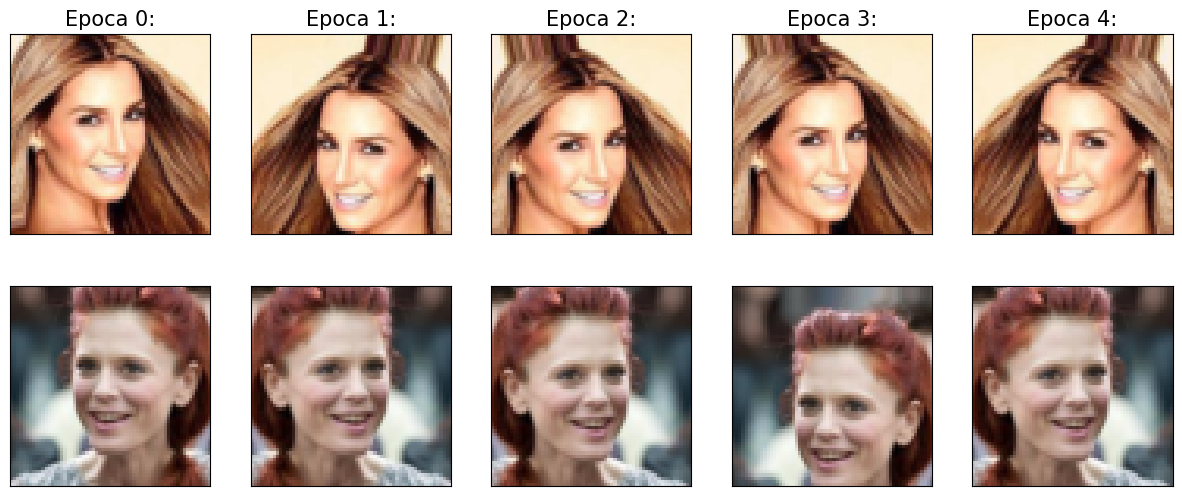

In [35]:
celeba_train_dataset = torchvision.datasets.CelebA(
    image_path, split='train',
    target_type= 'attr', download=False,
    transform=transform_train,
    target_transform=get_smile
)

torch.manual_seed(1)
data_loader = DataLoader(celeba_train_dataset, batch_size=2)
fig = plt.figure(figsize=(15,6))
num_epochs = 5

for j in range(num_epochs):
  img_batch, label_batch = next(iter(data_loader))
  img = img_batch[0]
  ax = fig.add_subplot(2, 5, j+1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(f'Epoca {j}:', size=15)
  ax.imshow(img.permute(1, 2, 0))

  img = img_batch[1]
  ax = fig.add_subplot(2, 5, j+6)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(img.permute(1, 2, 0))

plt.show()

Aplicamos la función de transformación a nuestro conjunto de validación y prueba

In [36]:
celeba_valid_dataset = torchvision.datasets.CelebA(
    image_path, split='valid',
    target_type='attr', download=False,
    transform=transform,
    target_transform=get_smile
)

celeba_test_dataset = torchvision.datasets.CelebA(
    image_path, split='test',
    target_type='attr', download=False,
    transform=transform,
    target_transform=get_smile
)

Nuestra intención es entrenar el modelo con un conjunto de datos pequeños, para reducir los datos de validación y entrenamiento ejecutamos el siguiente código

In [37]:
from torch.utils.data import Subset

celeba_train_dataset = Subset(celeba_train_dataset, torch.arange(16000))
celeba_valid_dataset = Subset(celeba_valid_dataset, torch.arange(1000))

print('Conjunto de entrenamiento:', len(celeba_train_dataset))
print('Conjunto de validación', len(celeba_valid_dataset))

Conjunto de entrenamiento: 16000
Conjunto de validación 1000


ahora crearemos los data loaders para los tres conjuntos de datos.

In [38]:
batch_size = 32 # Tamaño del lote
torch.manual_seed(1)
train_dl = DataLoader(celeba_train_dataset,
                      batch_size,
                      shuffle=True)
valid_dl = DataLoader(celeba_valid_dataset,
                      batch_size,
                      shuffle=False)
test_dl = DataLoader(celeba_test_dataset,
                     batch_size,
                     shuffle=False)

## Creación del modelo

La CNN recibe imágenes de tamaño 3×64×64 (64×64 pixeles y 3 canales de color) como entrada, estos datos pasan por cuatro capas convolucionales para generar 32, 64, 128 y 256 mapas de características usando filtros de tamaño 3×3. Las primeras tres capas convolucionales son seguidas por una capa de max-pooling $P_{2\times 2} $. Dos capas con Dropout son incluidas para regularizar.


In [39]:
import torch.nn as nn

In [40]:
model = nn.Sequential()

model.add_module(
    'conv1',
    nn.Conv2d(in_channels=3,
              out_channels=32,
              kernel_size=3,
              padding=1)
                )

model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout1', nn.Dropout(p=0.5))

model.add_module(
    'conv2',
    nn.Conv2d(in_channels=32,
              out_channels=64,
              kernel_size=3,
              padding=1)
                )

model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout2', nn.Dropout(p=0.5))

model.add_module(
    'conv3',
    nn.Conv2d(in_channels=64,
              out_channels=128,
              kernel_size=3,
              padding=1)
                )

model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))

model.add_module(
    'conv4',
    nn.Conv2d(in_channels=128,
              out_channels=256,
              kernel_size=3,
              padding=1)
                )

model.add_module('relu4', nn.ReLU())



Observemos las dimensiones de los mapas de características resultantes luego de aplicar estas capas usando un lote de juguete (4 imágenes arbitrarias):

In [41]:
x = torch.ones((4,3,64,64)) # Se crea un tensor de 4 elementos con 3 canales de tamaños 64x64 con 1 en todas sus entradas que podemos asemejar a 4 imágenes
model(x).shape

torch.Size([4, 256, 8, 8])

Para finalizar la arquitectura del modelo podemos agregar una capa densa para obtener una sola salida.

In [42]:
model.add_module('pool4', nn.AvgPool2d(kernel_size=8))
model.add_module('flatten', nn.Flatten())
model.add_module('fc', nn.Linear(256,1))
model.add_module('sigmoid', nn.Sigmoid())

model # imprimimos la arquitectura del modelo

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

El siguiente paso es crear una función de pérdida y un método de optimización. Para una clasificación binaria con una sola salida probabilistica podemos utilizar la función ```BCELoss``` como función de pérdida que corresponde a la función de entropía cruzada binaria (Binary Cross Entropy), mientras que un método de optimización bastante utilizado es ```adam``` (Adaptative moment estimation), el cual es una mejora del método del gradiente.



In [43]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Entrenamiento del modelo

In [44]:
def train(model, num_epochs, train_dl, valid_dl):
  loss_hist_train = [0] * num_epochs
  accuracy_hist_train = [0] * num_epochs
  loss_hist_valid = [0] * num_epochs
  accuracy_hist_valid = [0] * num_epochs

  for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_dl:
      pred = model(x_batch)[:,0]
      loss = loss_fn(pred, y_batch.float())
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch] += loss.item() * y_batch.size(0)
      is_correct = ((pred>=0.5).float() == y_batch).float()
      accuracy_hist_train[epoch] += is_correct.sum()
    loss_hist_train[epoch] /= len(train_dl.dataset)
    accuracy_hist_train[epoch] /= len(train_dl.dataset)

    model.eval()
    with torch.no_grad():
       for x_batch, y_batch in valid_dl:
         pred = model(x_batch)[:, 0]
         loss = loss_fn(pred, y_batch.float())
         loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
         is_correct = ((pred>=0.5).float() == y_batch).float()
         accuracy_hist_valid[epoch] += is_correct.sum()
    loss_hist_valid[epoch] /= len(valid_dl.dataset)
    accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

    print(f'Epoch {epoch+1} accuracy: '
      f'{accuracy_hist_train[epoch]:.4f} val_accuracy: '
      f'{accuracy_hist_valid[epoch]:.4f}')
  return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [46]:
torch.manual_seed(1)
num_epochs = 15
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.7071 val_accuracy: 0.7370
Epoch 2 accuracy: 0.7228 val_accuracy: 0.7560
Epoch 3 accuracy: 0.7332 val_accuracy: 0.7650
Epoch 4 accuracy: 0.7403 val_accuracy: 0.7820
Epoch 5 accuracy: 0.7486 val_accuracy: 0.7990
Epoch 6 accuracy: 0.7606 val_accuracy: 0.7930
Epoch 7 accuracy: 0.7707 val_accuracy: 0.7930
Epoch 8 accuracy: 0.7812 val_accuracy: 0.8070
Epoch 9 accuracy: 0.7947 val_accuracy: 0.8160
Epoch 10 accuracy: 0.8089 val_accuracy: 0.8270
Epoch 11 accuracy: 0.8182 val_accuracy: 0.8400
Epoch 12 accuracy: 0.8310 val_accuracy: 0.8520
Epoch 13 accuracy: 0.8419 val_accuracy: 0.8460
Epoch 14 accuracy: 0.8441 val_accuracy: 0.8620
Epoch 15 accuracy: 0.8489 val_accuracy: 0.8640


## Visualización de la exactitud y error del entrenamiento

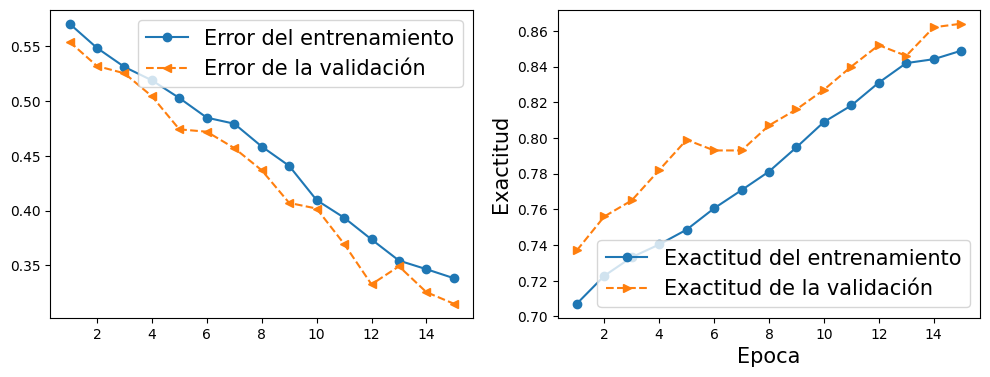

In [50]:
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, hist[0], '-o', label='Error del entrenamiento')
ax.plot(x_arr, hist[1], '--<', label='Error de la validación')
ax.legend(fontsize=15)
ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, hist[2], '-o', label='Exactitud del entrenamiento')
ax.plot(x_arr, hist[3], '-->', label='Exactitud de la validación')
ax.legend(fontsize=15)
ax.set_xlabel('Epoca', size=15)
ax.set_ylabel('Exactitud', size=15)
plt.show()

## Evaluación del modelo

In [51]:
accuracy_test = 0

model.eval()
with torch.no_grad():
  for x_batch, y_batch in test_dl:
    pred = model(x_batch)[:, 0]
    is_correct = ((pred>=0.5).float() == y_batch).float()
    accuracy_test += is_correct.sum()
accuracy_test /= len(test_dl.dataset)
print(f'Exactitud de la prueba: {accuracy_test:.4f}')

Exactitud de la prueba: 0.8497


## Predicciones del modelo

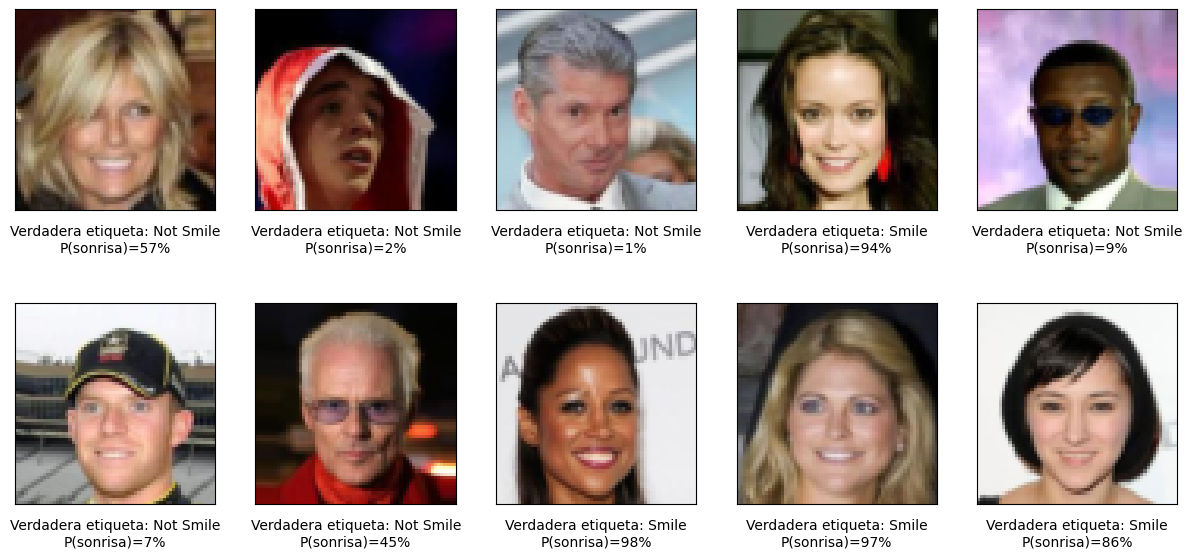

In [53]:
pred = model(x_batch)[:,0]*100
fig = plt.figure(figsize=(15, 7))
for j in range(10, 20):
  ax = fig.add_subplot(2, 5, j-9)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(x_batch[j].permute(1, 2, 0))
  if y_batch[j] == 1:
    label='Smile'
  else:
    label = 'Not Smile'
  ax.text(
      0.5, -0.15,
      f'Verdadera etiqueta: {label:s}\nP(sonrisa)={pred[j]:.0f}%',
      size=10,
      horizontalalignment='center',
      verticalalignment='center',
      transform=ax.transAxes
  )
plt.show()